# Auto-Encoder in Pytorch

In this tutorial we will introduce and implement auto-encoders. An exaple is shown in the image below. 

![autoencoder](https://drive.google.com/uc?export=download&id=10sZv98I38nAKqhyVtZPHkmCeeNPgKn6r)

An encoder consists of three parts:

1. encoder (higher dimension -(compress)- lower dimension)
2. encoded layer 
3. decoder (lower dimension -(decompress)- higher dimension)

The image also shows that the input and the expected output are the same. Therefore an autoencoder approximates an identity function for a specific input space (e.g.: MNIST images). The output of the autoencoder is called the reconstruction of the input and that motivates naming the corresponding loss as reconstruction loss.

The encoder contains bottleneck (in the image the encoded layer) which is smaller then the input. Therefore a successful reocnstruction is possible if the autoencoder manages to find a lower dimensional representation of the input space. This is because to reconstruct the original input at the output requires that all of the information is available for the reconstruction in the decoder. The information flows from layer to layer and it should not loss (at least radically). As a consequence the representation of the input is the most dense in the encoded layer because it is the smallest one.

Beyond a well-chosen architecture the loss and regularization are very important. There are different types of autoencoders. Basically there are two main groups, the first one is the undercomplete autoencoders and second one is the regularized autoencoders. Of course the second one is wider. Undercomplete autoencoder just uses a narrower encoded layer and a suitable loss function. On the other hand, regularized autoencoder uses a regularization on the *encoded layer*. The type of the used regularization technique differentiate the autoencoder types:

* basic autoencoder
* sparse autoencoder
* contractive autoencoder
* denoising autoencoder
* variational autoencoder.

And of course, it is possible to figure out new ones but these are the most common approaches. Let's go through them then implement the contractive autoencoder and the variational autoencoder. 

### Basic autoencoder

Mostly, in the literature basic autoencoder has a one layer encoder and a one layer decoder with sigmoid activations. There is no regularization. Typical losses are Mean Squared Error (MSE) and Binary Cross-entropy (BCE). 

### Sparse autoencoder

A sparse autoencoder tries creating sparse encodings. Sparse means that most of the values in the encodings are low, close to zero while some of them is high (when the neuron is activated). This autoencoder can be good for (for example) creating features for further classifications. Losses: MSE, BCE. For regularization L1 and L2 or the most common one is a Kullback-Leibler divergence based term:

\begin{equation}
L_r = \sum_j^J{KL\left(\rho||\rho_j\right)} = \sum_j^J{\rho \log{\frac{\rho}{\rho_j}} + (1-\rho) \log{\frac{1-\rho}{1-\rho_j}}},
\end{equation}

where $\rho_j$ is the average activation of the ($j^{th}$) neuron in the encoded layer, $\rho$ is a small value (like 0.05) to enforce the unimportant nodes to be low and this forces the sparsity. 

\begin{equation}
\rho_j = \frac{1}{I}\sum_i^I{a_j(x_i)},
\end{equation}

here the summation goes over the number of samples in the training data (or batch in case of stochastic descent). 

### Contractive autoencoder

The goal of the contractive autoencoder is to make the autoencoder less sensitive to noise or saying it in an other way, make it locally more resistent to small changes. This can help to achieve better generalization capabilities. Losses are MSE, BCE and others. The regularization term uses the Frobenius-norm of the so called Jacobian-matrix. The Jacobian-matrix shows how the output changes if the input changes a bit and the Frobenius-norm describes this sensitivity with one number. Now the details with some further explanations. Jacobi-matrix:

\begin{equation}
J_{ij} = \frac{\partial y_i}{\partial x_j}.
\end{equation}

Such a matrix is the gradient of the so called vector-vector functions. As the name suggests in a vector-vector function the input is a vector and the output is a vector. In an autoencoder we have a multidimensional input, which can be represented by a vector, and the output is the activations in the encoded layer, which can be also represented by a vector. The elements of the Jacobian basically shows how the input-output element pairs relates in terms of a derivative. So a row of the matrix shows if we change a pixel in the input image (suppose it is gray scaled and it has only one channel) then how the activation value in each neurons of the encoded layers will change. 

The Frobenius-norm can be defiened as it induced by a vector norm, specifically the 2-norm. Here is the mathematical definition then the concrete one:

\begin{equation}
|| A ||_F = \sup_v \frac{|| A v ||_2}{|| v ||_2}
\end{equation}

\begin{equation}
|| A ||_F = \left( \sum_{i, j}{a^2_{ij}} \right)^\frac{1}{2}
\end{equation}

Now the regularization term:

\begin{equation}
L_r = \left( \sum_{i, j}{\left(\frac{\partial y_i}{\partial x_j}\right)^2} \right)^\frac{1}{2}.
\end{equation}

### Denoising autoencoder

The goal of the denoising autoencoder is somewhat similar to the contractive autoencoder's. The denoising autoencoder helps to make the encoder more flexibel against noise and can prevent overfitting because the autoencoder never sees the same input again but a similar one. Here the data set is augmented by applying noise on the input when it is fed into the network. It is not typical to use regularization term as well.

### Variational autoencoder

This encoder is a generative model. This means that the result of the learning is a model which can be used to generate outputs like the inputs but from noise. So the training goes as in case of the autoencoders but then the encoded layer is not used as a compressed representation but instead we generate random values for the encoded layers and then propagate forward through the decoder. The result should be similar to the samples in the training data sets. (This is implemented in the codes below.) Let's see how does it work! 

Here the regularization term and the structure of the encoded layer is important. The reconstruction loss can be anything but usually it is MSE or BCE (in the implementation we will use BCE). 

Now we introduce briefly how VAE works and more theoretical details can be seen at the end of this tutorial. The total loss function in a VAE ($\overline{x}$ is the output): 

\begin{equation}
L = BCE(x, \overline{x}) + KL\left( q(z|x)||p(z) \right).
\end{equation}

$p(z)$ is chosen as a standard normal distribution ($N(0, 1)$). $q(z|x)$ is given by the encoder. But it is difficult to generate a distribution directly therefore we use normal distribution and the encoder layer approximates the mean and the standard deviation. Both of them is a vector. Basically the encoder has two output vectors, the mean and the standard deviation. 

Calculating the Kullback-Leibler divergence between normal-distributions can be calculated in a close forme (in the formula $\mu$, $\sigma$ is just a scalar):

\begin{equation}
KL\left( N(\mu, \sigma) || N(0, 1) \right) = \frac{1}{2} (\mu^2 + \sigma^2 - 1 - \log\sigma^2).
\end{equation}

Because we have distribution in the encoded layer we need to sample a vector from $N(\mu, \sigma)$ but with a direct sampling the backpropagation would not be possible. Therefore we apply the so called reparametrization trick. So:

\begin{align}
\epsilon \leftarrow N(0, 1) \\
z = \mu + \sigma \cdot \epsilon.
\end{align}

$z$ is the sampled vector and this will be fed into the decoder part. The image below summarizes the structure of the VAE. $\mu$ and $\sigma$ have the same size. 

![vae](https://drive.google.com/uc?export=download&id=1RXLJTtvUc6OiWddgmVp5QXE4eUjhi_vQ)

References: 

[Contractive autoencoder](http://www.icml-2011.org/papers/455_icmlpaper.pdf)
[Variational autoencoder](https://arxiv.org/pdf/1606.05908.pdf)

## Implementation

In the implementation first we are dealing with the CAE and two ways how to calculate the Frobenius-norm. The second implementation is the VAE. We will see that the CAE can easily solve the reconstruction but it is hardly able to generate new numbers however the VAE is able to reconstruct and generate new images from noise. 

In [1]:
%matplotlib inline
%config IPCompleter.greedy=True # this line is for autocomplete

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import TensorDataset, DataLoader
from pckutils import mnist, utils
import json
from matplotlib import pyplot as plt
import time
import psutil

## Checking gradients of CAE

In [3]:
class AutoGradCAE(nn.Module):
    
    def __init__(self, in_f, out_f):
        super(AutoGradCAE, self).__init__()
        self.in_fetaures = in_f
        self.out_features = out_f
        
        # important to create here all the functions which contain parameters to be trained
        # otherwise model.parameters() would return an empty list
        self.lin_enc = nn.Linear(self.in_fetaures, self.out_features)
        self.lin_dec = nn.Linear(self.out_features, self.in_fetaures)
    
    def forward(self, x):
        x.requires_grad=True # this is for taking the gradient according to x as well
        self.y_enc = torch.sigmoid(self.lin_enc(x))
        self.ae_reg = self.__jacobi(x, self.y_enc)
        y_out = torch.sigmoid(self.lin_dec(self.y_enc))
        return y_out
    
    def __jacobi(self, x, y):
        j_frobenius = 0.0
        for b in range(x.size(0)):
            for i in range(self.out_features):
                # creat_graph is important because we will calculate the gradient of j_frobenius according to model parameters
                gradients = grad(y[b, i], x, retain_graph=True, create_graph=True)[0] 
                j_frobenius += gradients.pow(2).sum()
        return j_frobenius

In [4]:
x = torch.rand((1, 20), requires_grad=True)
bae = AutoGradCAE(20, 5)
y = bae(x)

In [5]:
bae.ae_reg

tensor(0.0986, grad_fn=<ThAddBackward>)

In [6]:
ws = []
for p in bae.parameters():
    ws.append(p.data)

In [7]:
criterion = nn.MSELoss()
loss = criterion(y, x) + bae.ae_reg
bae.zero_grad()
loss.backward()

In [8]:
# derivative of Jacobi term according to W and b
w = ws[0]
w.requires_grad=True
b = ws[1]
b.requires_grad=True

s = torch.sigmoid(torch.matmul(w, x[0]) + b)
ou = torch.matmul(torch.diag(s * (1-s)), w).norm().pow(2) # manual calculation of the Frobenius norm of the Jacobian
j_w = grad(ou, w, retain_graph=True)[0]
j_b = grad(ou, b, retain_graph=True)[0]

In [9]:
# derivative according to the decoder W and b parameters
sigm_deriv = y[0] * (1-y[0])
sigm_jacobi = torch.diag(sigm_deriv)
dec_b = torch.matmul(y[0]-x[0], sigm_jacobi) * 2
dec_w = torch.ger(dec_b, bae.y_enc[0])

# derivative according to the encoder W and b parameters
delta = torch.matmul(torch.matmul((y[0]-x[0]), sigm_jacobi), ws[2])
enc_b = torch.matmul(delta, torch.diag(bae.y_enc[0] * (1-bae.y_enc[0]))) * 2
enc_w = torch.ger(enc_b, x[0])

In [10]:
for p, calc_grad in zip(bae.parameters(), [enc_w + j_w, enc_b + j_b, dec_w, dec_b]):
    assert torch.le(torch.abs(p.grad - calc_grad), 1e-7).sum() == calc_grad.numel()
print('Gradients are OK!')

Gradients are OK!


## MNIST example for CAE and VAE

Read the MNIST dataset. 

In [11]:
data = mnist.load_mnist('data')

2051 60000 28 28
Reading images: [100%]
2049 60000
Reading labels: [100%]
2051 10000 28 28
Reading images: [100%]
2049 10000
Reading labels: [100%]


In [12]:
# creating a black and white (binary) image from the grayscale one
# normalize it to 0 (black) and 1 (white)
# creates train loader to draw batches
x_binary = utils.create_binary_image(data.X_train) 
X = torch.Tensor(x_binary)
tensors = TensorDataset(X)
trainloader = DataLoader(tensors, batch_size=128, shuffle=True)

### CAE

Unfortunately, calculating the gradient with autograd is too time consuming and requires much more memory then it is reasonable. To see this lets try it on the following example with random inputs and measure the time of execution.

In [13]:
# generate random data (MNIST is difficult to run due to its huge memory requirements)
rt = torch.round(torch.rand(128, 100))
random_ts = TensorDataset(rt)
rand_trainloader = DataLoader(random_ts, batch_size=16, shuffle=True)

In [14]:
# create a function for later usage
def train_ae(ae, trainloader, lr, beta, device):
    ae.device = device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    running_loss_reg = 0.0
    running_loss_rec = 0.0
    cntr = 0
    
    vmem = 0.0
    start = time.clock()
    for epoch in range(10):
        for i, batch in enumerate(trainloader, 1):
            cntr += 1
            
            optimizer.zero_grad()#never forget this! without this the gradients are accumulated therefore learning will slow down
            x = batch[0]
            x = x.to(device)
        
            y = ae(x)
            loss_reg = beta * ae.ae_reg
            loss_rec = criterion(y, x)
            loss = loss_reg + loss_rec
            loss.backward()
            vmem += psutil.virtual_memory()[2]
            optimizer.step()
        
            running_loss_reg += loss_reg.item()
            running_loss_rec += loss_rec.item()
        if (epoch + 1) % 10 == 0:
            print('[%3d, %3d] loss_reg: %.3f  loss_rec: %.3f' %
                (epoch + 1, i, running_loss_reg / 200, running_loss_rec / 200))
            running_loss_reg = 0.0
            running_loss_rec = 0.0
    end = time.clock()

    print("Ellapsed time: %.5f, memory: %.2f" %(end - start, vmem/cntr))

device = torch.device("cpu")
ae = AutoGradCAE(100, 50).to(device)
train_ae(ae, rand_trainloader, 1e-3, 5e-4, device)

[ 10,   8] loss_reg: 0.003  loss_rec: 158.098
Ellapsed time: 15.63380, memory: 48.25


To speed up we need calculating the gradient by the input manually in **batch** mode. 

In [15]:
class MNISTautoencoderCAE(nn.Module):
    
    def __init__(self, in_f, out_f):
        super(MNISTautoencoderCAE, self).__init__()
        self.in_f = in_f
        self.out_f = out_f
        
        self.lin_enc = nn.Linear(in_f, out_f)
        self.lin_dec = nn.Linear(out_f, in_f)
        
    def forward(self, x):
        '''
        x - batch_size x in_f
        '''
        y_encoded = torch.sigmoid(self.lin_enc(x))
        self.ae_reg = self.jacobi_loss_calc(y_encoded)
        y_out = torch.sigmoid(self.lin_dec(y_encoded))
        return y_out
    
    def jacobi_loss_calc(self, y):
        sigmoid_der = y * (1-y)
        w = list(self.lin_enc.parameters())[0]
        sigmoid_der_2 = sigmoid_der**2
        w_2 = w**2
        return torch.sum(torch.matmul(sigmoid_der_2, w_2))
    
    def generate_image(self):
        x_random = torch.rand(self.out_f)
        return torch.sigmoid(self.lin_dec(x_random))
    
    def generate_image_from_random(self, x_random):
        return torch.sigmoid(self.lin_dec(x_random))

### Checking if this simpler form is right

In [16]:
x = torch.rand((32, 20))*20
mae = MNISTautoencoderCAE(20, 5)
bae = AutoGradCAE(20, 5)

for mae_p, bae_p in zip(mae.parameters(), bae.parameters()):
    mae_p.data = bae_p.data

In [17]:
mae_y = mae(x).data
bae_y = bae(x).data
torch.eq(mae_y, bae_y).sum() == torch.numel(mae_y)

tensor(1, dtype=torch.uint8)

In [18]:
mae.ae_reg.item()

0.4723227620124817

In [19]:
bae.ae_reg.item()

0.47232282161712646

The two are the same. 

### Measuring ellapsed time during training

In [20]:
device = torch.device("cpu")
ae = MNISTautoencoderCAE(100, 50).to(device)
train_ae(ae, rand_trainloader, 1e-3, 5e-4, device)

[ 10,   8] loss_reg: 0.002  loss_rec: 0.099
Ellapsed time: 0.07627, memory: 48.30


This is much faster. If you try it with the MNIST dataset you can experience running out of memory in case of the autograd-based implementation!

Now, train on MNIST and check the quality of encoding by using the test set:

In [21]:
device = torch.device("cpu")
ae = MNISTautoencoderCAE(784, 400).to(device)
train_ae(ae, trainloader, 1e-3, 5e-4, device)

x_test = utils.create_binary_image([data.X_test[12]])
y = ae(torch.tensor(x_test[0]).view(1, -1).to(device))

[ 10, 469] loss_reg: 0.190  loss_rec: 1.526
Ellapsed time: 112.84297, memory: 48.23


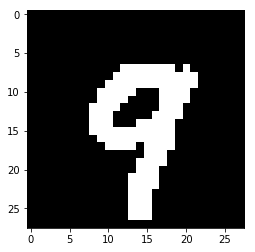

In [22]:
# original
plt.imshow(x_test[0].reshape((28, 28)), cmap='gray')

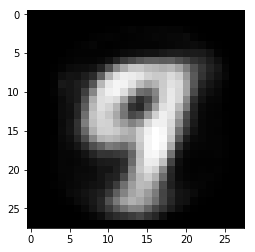

In [23]:
# reconstructed
plt.imshow(y.detach().numpy().reshape((28, 28)), cmap='gray')

### VAE

In [24]:
class MNISTautoencoderVAE(nn.Module):
    
    def __init__(self, feature_in, feature_out):
        super(MNISTautoencoderVAE, self).__init__()
        self.feature_in = feature_in
        self.feature_out = feature_out
        
        self.lin_enc1 = nn.Linear(feature_in, 600)
        self.lin_enc2 = nn.Linear(600, 500)
        self.lin_enc_mu = nn.Linear(500, feature_out)
        self.lin_enc_std = nn.Linear(500, feature_out)
        
        self.lin_dec1 = nn.Linear(feature_out, 500)
        self.lin_dec2 = nn.Linear(500, 600)
        self.lin_dec3 = nn.Linear(600, feature_in)
        
        self.ae_reg = 0.0
        self.device = 0.0
        
    def forward(self, x):
        # encoder part
        x_ = torch.relu(self.lin_enc1(x))
        x_ = torch.relu(self.lin_enc2(x_))
        mu = torch.tanh(self.lin_enc_mu(x_)) # mean
        std = torch.relu(self.lin_enc_std(x_)) + 1e-8 # standard deviation
        samples = torch.normal(torch.zeros(mu.size(0), self.feature_out), torch.ones(mu.size(0), self.feature_out)).to(self.device)
        self.u = mu + std * samples # reparametrization trick
        
        # calculate the regularization part
        self.ae_reg = self.calculate_reg(mu, std)
        
        # decoder
        y_ = torch.relu(self.lin_dec1(self.u))
        y_ = torch.relu(self.lin_dec2(y_))
        return torch.sigmoid(self.lin_dec3(y_))
    
    def calculate_reg(self, mu, std):
        kl_div = 0.5 * (std*std + mu*mu - 1.0 - torch.log(std*std))
        return kl_div.sum()/mu.size(0) # devide by the batch_size
    
    def generate_image(self):
        x_random = torch.normal(torch.zeros(self.feature_out), torch.ones(self.feature_out)).to(self.device)
        y_ = torch.relu(self.lin_dec1(x_random))
        y_ = torch.relu(self.lin_dec2(y_))
        return torch.sigmoid(self.lin_dec3(y_))

In the reparametrization trick we have to draw samples from a standard normal distribution. It is important to draw different samples for each element in the batch. It can be seem unimportant and maybe one can draw only one sample and use it for a batch of $\mu$ and $\sigma$. Unfortunately in this case the VAE will hardly learn. The different samples are important to increase the number of elements because it helps to approximate the underlying distribution more smoothly. (Law of large numbers)

### Training the autoencoder

In [25]:
device = torch.device("cuda:0")
mae = MNISTautoencoderVAE(28*28, 400).to(device)
mae.device = device
criterion = nn.BCELoss()
optimizer = optim.Adam(mae.parameters(), lr=1e-3)
running_loss_reg = 0.0
running_loss_rec = 0.0
cntr = 0

for epoch in range(60):
    for i, batch in enumerate(trainloader, 1):
        
        optimizer.zero_grad()
        
        x = batch[0]
        x = x.to(device)
        
        y = mae(x)
        loss_reg = 5e-4*mae.ae_reg
        loss_rec = criterion(y, x)
        loss = loss_reg + loss_rec
        loss.backward()
        optimizer.step()
        
        running_loss_reg += loss_reg.item()
        running_loss_rec += loss_rec.item()
        cntr += 1
    if (epoch+1) % 10 == 0:
        print('[%3d, %3d] loss_reg: %.3f  loss_rec: %.3f' %
            (epoch + 1, i, running_loss_reg / cntr, running_loss_rec / cntr))
        running_loss_reg = 0.0
        running_loss_rec = 0.0
        cntr = 0

[ 10, 469] loss_reg: 0.046  loss_rec: 0.113
[ 20, 469] loss_reg: 0.023  loss_rec: 0.077
[ 30, 469] loss_reg: 0.023  loss_rec: 0.066
[ 40, 469] loss_reg: 0.033  loss_rec: 0.071
[ 50, 469] loss_reg: 0.037  loss_rec: 0.067
[ 60, 469] loss_reg: 0.068  loss_rec: 0.065


In [45]:
# save the weights
weights = list(map(lambda x: x.cpu().detach().numpy(), mae.parameters()))
utils.save_parameters(weights, "weights/Autoencoder.json")

In [ ]:
# load the weights if necessary (to try other things for example you do not need to train)
weights = utils.load_parameters("weights/Autoencoder.json")
mae = MNISTautoencoderCAE(28*28, 400)
pms = list(map(torch.from_numpy, weights))

for i, p in enumerate(mae.parameters()):
    p.data = pms[i]

### Checking input and output visually

In [26]:
x_test = utils.create_binary_image([data.X_test[12]])
y = mae(torch.tensor(x_test[0]).view(1, -1).to(device))

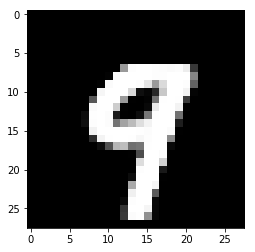

In [27]:
plt.imshow(y.cpu().detach().numpy().reshape((28, 28)), cmap='gray')

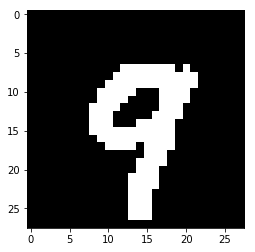

In [28]:
plt.imshow(x_test[0].reshape((28, 28)), cmap='gray')

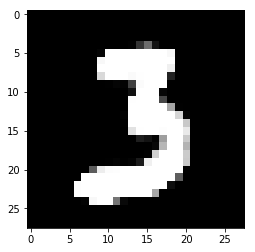

In [42]:
# variational encoder for generating numbers
img = mae.generate_image()
plt.imshow(img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')

It can be seen that the images are tend to be mimic images from the dataset. But here we just put randomly generated values into the encoded layer. That is why this is a generative model (and not discriminative).

## Derivations for VAE

Let's suppose we know the joint distribution of x and z, p(x, z). Then we can calculate p(x) and p(z) as marginal probabilities by summing out the z and x, respectively. Basically the task of the autoencoder is to learn a mapping between z and x ($x\rightarrow z$). We do not know the exact formula but we can approximate the distribution. The correct mapping we do not know is $p(z|x)$ and its approximation is $q(z|x)$. Then what we want is to minimize the difference between them. The KL divergence can express this:

\begin{equation}
KL(q(z|x)||p(z|x)).
\end{equation}

Then take into account the Bayes-rule because we can not calculate the formula above:

\begin{equation}
p(z|x) = \frac{p(x|z)p(z)}{p(x)}.
\end{equation}

Substitute this into the KL-divergence above:

\begin{align}
KL(q(z|x)||p(z|x)) &= E_q \log q(z|x) - E_q \log p(x|z) - E_q \log p(z) + E_q \log p(x) \\
&= -E_q \log p(x|z) + KL(q(z|x)||p(z)) + \log p(x).
\end{align}

The $\log p(x)$ does not depend on $q$ and that is the reason for deleting the expectation. The distribution of the input is fixed therefore its gradient does not change. As a consequence, minimizing the KL divergence at the left hand side is the same as minimizing the

\begin{equation}
-E_q \log p(x|z) + KL(q(z|x)||p(z))
\end{equation}

function. We assume $p(z)$ is a standard normal distribution. We know nothing about $p(x|z)$ therefore we use an energy based approach for its calculation:

\begin{equation}
p(x|z) = \frac{e^{-E(x, z)}}{Z}.
\end{equation}

The choice of the energy ($E$) can be aligned with MSE or BCE or other well known loss functions. Finally we got the equation:

\begin{equation}
BCEloss(x, \overline{x}) + KL(q(z|x)||p(z))
\end{equation}

### Kullback-Leibler divergence between normal distributions

\begin{align}
KL\left( N(\mu, \sigma) || N(0, 1) \right) &= \int_{-\infty}^\infty{f(x) \log\frac{f(x)}{f_0(x)} dx} \\
f(x) &=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} \\
f_0(x) &=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
\end{align}

Then taking the logarithms:

\begin{align}
\log f(x) &= -\log \sqrt{2 \pi} - \log \sigma - \frac{(x - \mu)^2}{2\sigma^2} \\
\log f_0(x) &= -\log \sqrt{2 \pi} - \frac{x^2}{2}
\end{align}

The substraction of the two logarithm eliminates the $-\log \sqrt 2\pi$ part. Then continuing the integration:

\begin{align}
KL(.||.) &= \int_{-\infty}^\infty\left( f(x) \log f(x) - f(x) \log f_0(x) \right) dx \\
&= \int_{-\infty}^\infty -f(x) \log \sigma dx + \int_{-\infty}^\infty f(x) \left( \frac{x^2}{2} - \frac{(x-\mu)^2}{2\sigma^2} \right) dx \\
&= -\log \sigma + \int_{-\infty}^\infty f(x) \left( \frac{x^2}{2} - \frac{(x-\mu)^2}{2\sigma^2} \right) dx.
\end{align}

Here we taken into account that $\int_{-\infty}^\infty f(x) dx = 1$. Now we reformulate the second term:

\begin{equation}
\frac{x^2}{2} - \frac{(x-\mu)^2}{2\sigma^2} = \underbrace{\left( \frac{1}{2} - \frac{1}{2\sigma^2} \right)x^2}_{A} + \underbrace{\frac{\mu}{\sigma^2}x}_{B} - \underbrace{\frac{\mu^2}{2\sigma^2}}_{C}
\end{equation}

\begin{align}
A&: \int_{-\infty}^\infty{\sigma^2 \left( \frac{1}{2} - \frac{1}{2\sigma^2} \right) \frac{x - \mu + \mu}{\sigma^2}f(x)dx} = \sigma^2 \left( \frac{1}{2} - \frac{1}{2\sigma^2} \right) \left( 1 + \frac{\mu^2}{\sigma^2} \right) 
= \frac{1}{2} \left( \sigma^2 + \mu^2 - 1 - \frac{\mu^2}{\sigma^2} \right)\\
B&: \int_{-\infty}^\infty \frac{\mu}{\sigma^2} x f(x)dx = \frac{\mu}{\sigma^2} (x-\mu+\mu)f(x)dx = \frac{\mu^2}{\sigma^2} \\
C&: \int_{-\infty}^\infty -\frac{\mu^2}{\sigma^2} f(x) dx = -\frac{\mu^2}{2\sigma^2}.
\end{align}

Where we used the following:

\begin{align}
\frac{x-\mu}{\sigma^2}f(x) = \frac{\partial f(x)}{\partial x} \\
\int_{-\infty}^\infty \frac{\partial f(x)}{\partial x} dx = 0
\end{align}

and integration by parts is also necessary to calculate the results above.

Finally, we got:

\begin{equation}
KL\left( N(\mu, \sigma) || N(0, 1) \right) = \frac{1}{2}\left( \mu^2 + \sigma^2 - 1 - \log\sigma^2 \right)
\end{equation}